# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching
import logging
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [10]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=modern'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda:2') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 8
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: false
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: cosine-decay
  langevin_noise: 0.1
  warmup: 50
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 2
    outer_exp: 0.5
    double_opponents: true
  orthogonality:
    scale: 0.0
  norm:
    scale: 1.0e-06
    pnorm: 2
  deep_inversion:
    scale: 0.001



{'device': device(type='cuda', index=2), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [34]:
# cfg.dryrun = False
# cfg.attack.optim.step_size=1.0
cfg.case.user.data_idx = 0
cfg.case.user.num_data_points = 8

cfg.case.model = 'resnet50'
cfg.case.server.model_state = 'pretrained'

cfg.attack.optim.langevin_noise = 0.00
cfg.attack.restarts.num_trials = 1
cfg.attack.regularization.deep_inversion.scale=0.0

### Instantiate all parties

In [35]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Model architecture <class 'torchvision.models.resnet.ResNet'> loaded with 25,557,032 parameters and 53,173 buffers.
Overall this is a data ratio of      21:1 for target shape [8, 3, 224, 224] given that num_queries=1.


In [36]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 8
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ResNet
            loss function: CrossEntropyLoss()

            Data:
            Dataset: ImageNet
            data_idx: 0
        


### Simulate an attacked FL protocol

In [37]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# True user data is returned only for analysis

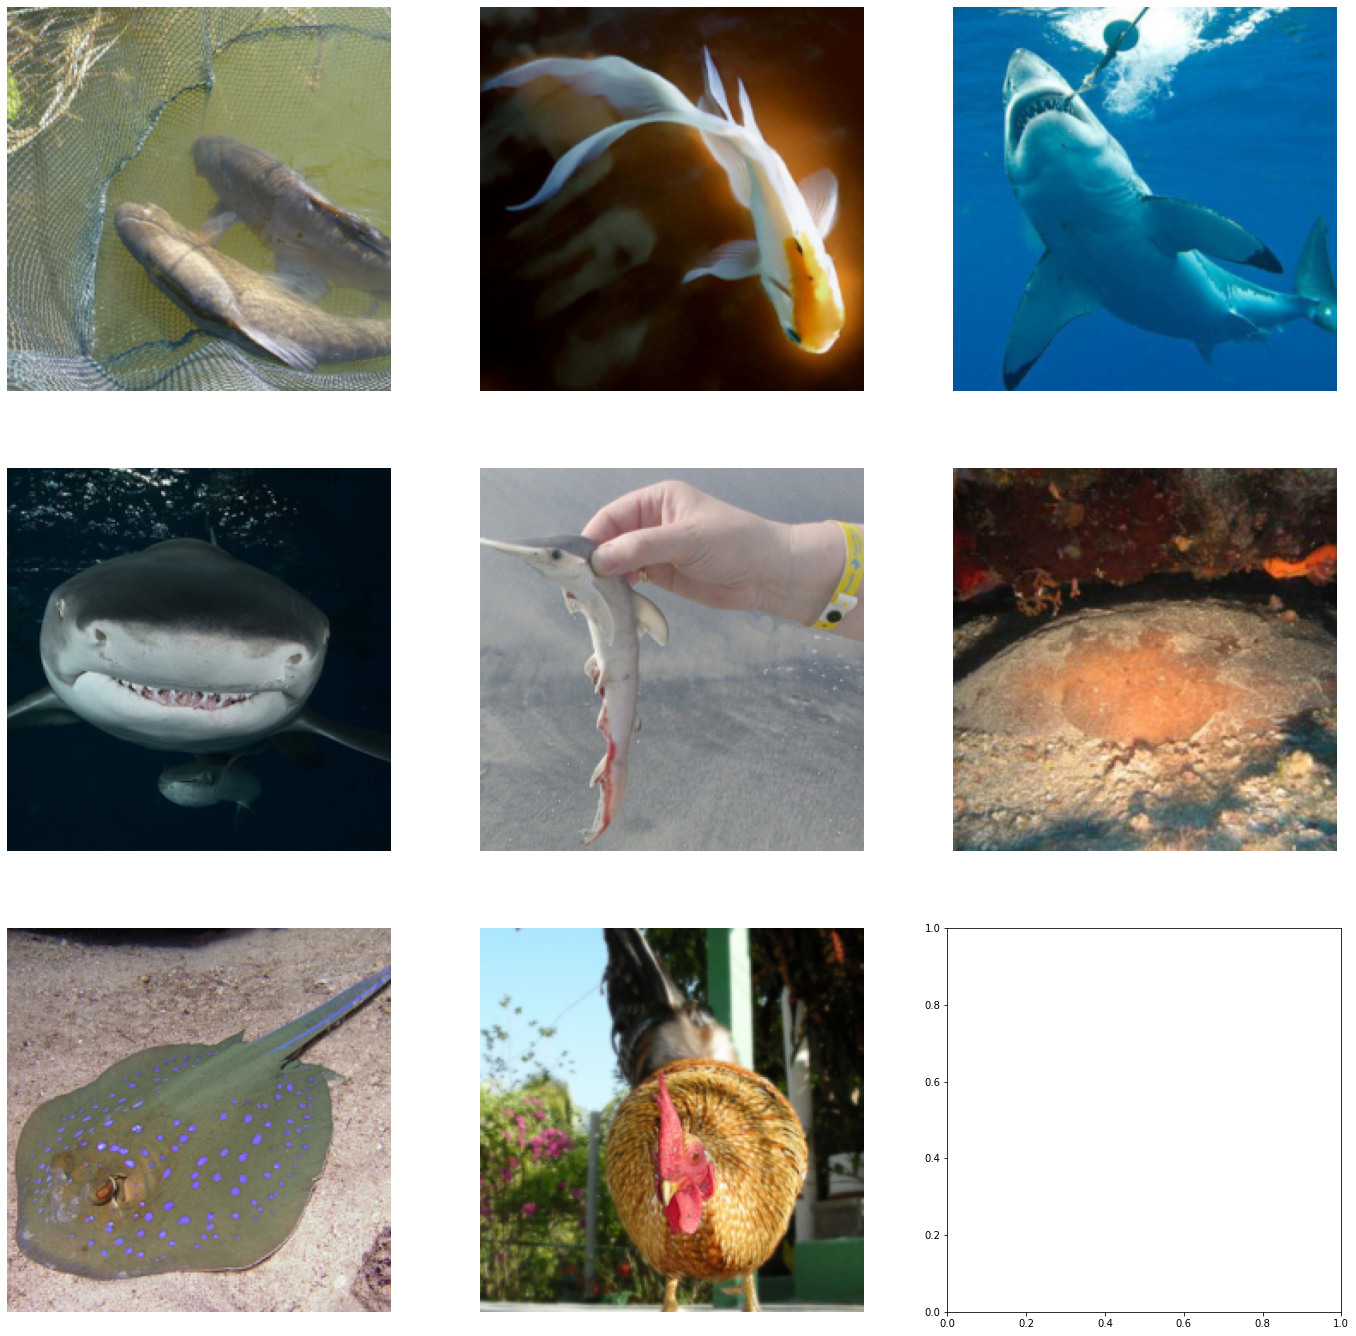

In [38]:
user.plot(true_user_data)

### Reconstruct user data:

In [ ]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

It: 1. Rec. loss: 1.4212. T: 0.20s


In [ ]:
user.plot(reconstructed_user_data)

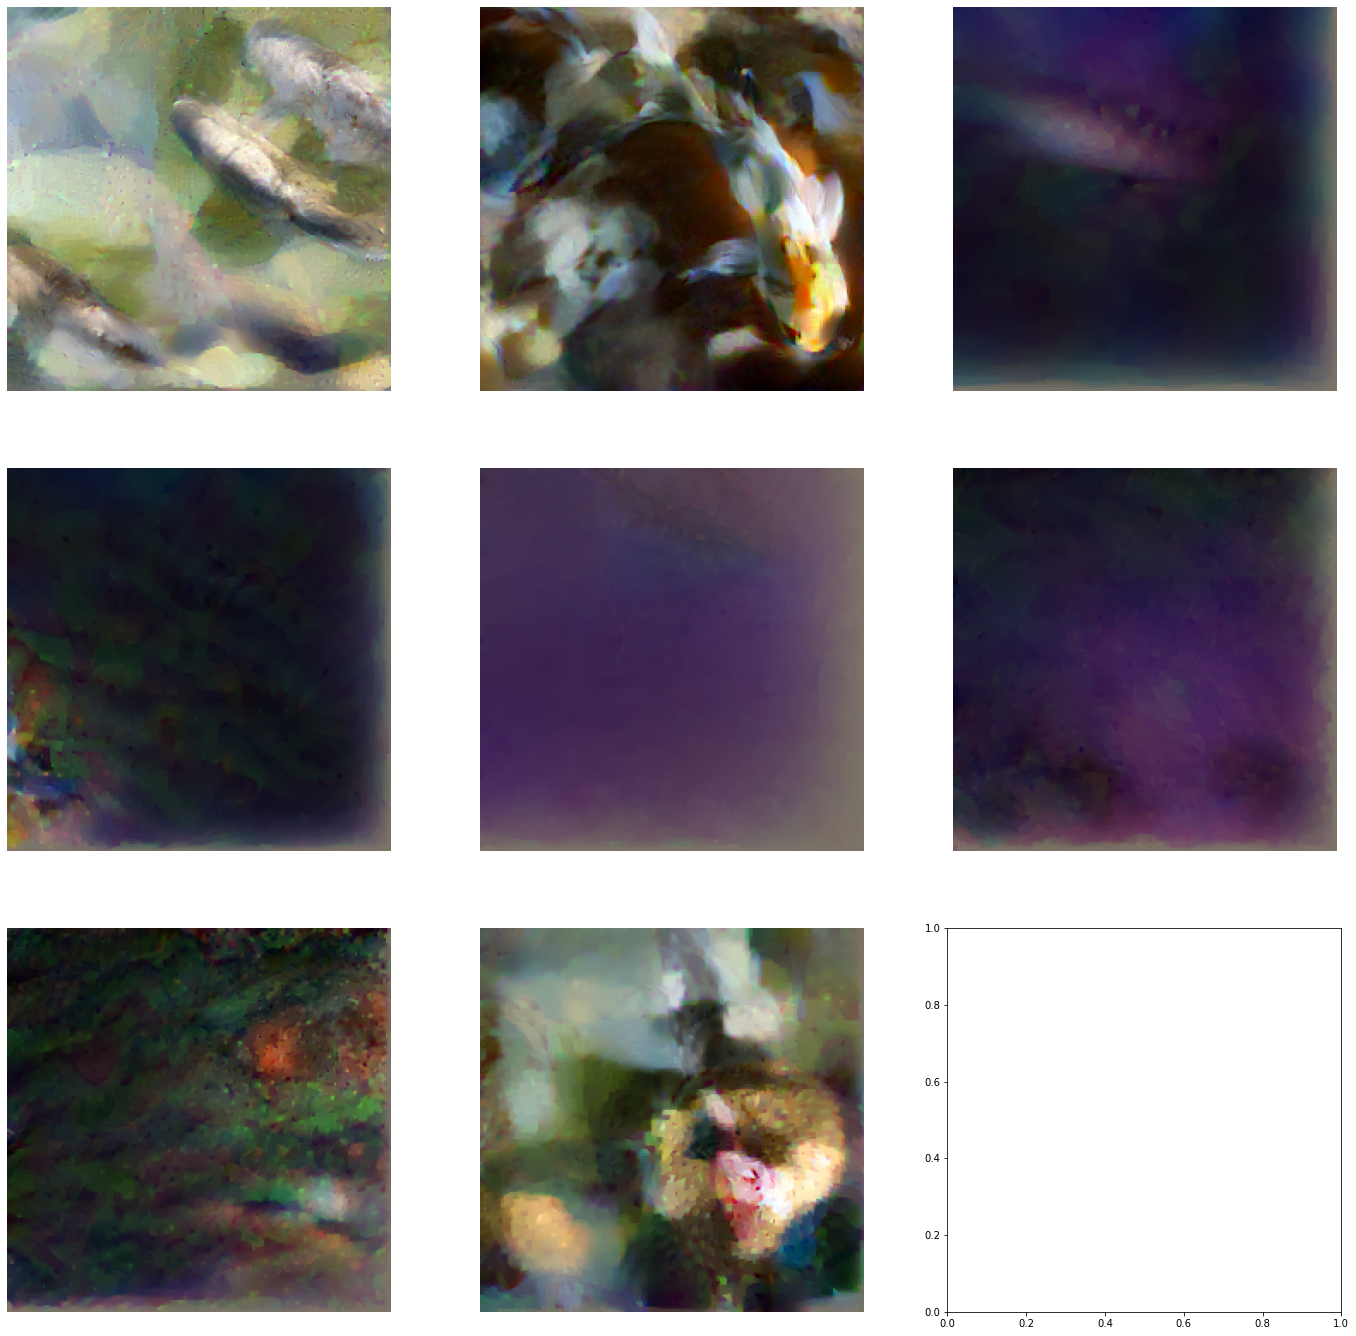

In [9]:
user.plot(reconstructed_user_data)